## Attribution

This code is adapted from Social Media Analytics (SIADS 682) Week 4 assignment. The original notebook was developed by Dr. Eric Gilbert
([eegg@umich.edu](mailto:eegg@umich.edu)).

The Winter 2023 course was taught by Erik Lang ([eriklang@umich.edu](mailto:eriklang@umich.edu)), with support from Jake Huang ([yiju@umich.edu](mailto:yiju@umich.edu)) and Alexander Levin-Koopman ([alevink@umich.edu](mailto:alevink@umich.edu)).


In [1]:
# !pip install matplotlib==3.8.1
# !pip install seaborn==0.13.0

import matplotlib
import seaborn

from langchain_core.documents import Document
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import pickle
import re
from typing import List, Tuple
import json
import textwrap


matplotlib.__version__, seaborn.__version__

('3.8.3', '0.13.2')

In [2]:
# Load from persistent store
persist_directory = "./embeddings"

with open(f"{persist_directory}/documents.pickle", "rb") as handle:
    documents: List[Document] = pickle.load(handle)

documents[:5]

[Document(page_content="Math Methods I (SIADS 502), Course Syllabus Mads 502: Math Methods For Data Science Course Overview: There are no prerequisites for this course. This course will review and introduce some mathematical concepts relevant to applied data science. It will cover important concepts in linear algebra, probability, and statistics. Week 1 covers some math basics about sets, types of numbers, types of proofs, functions, derivatives, optimization, exponents, logarithms, Euler's number, and natural logarithms. It also covers Part 1 of the unit on Linear Algebra, specifically vector operations with math and with Python and the concepts of span, basis, and linear independence. Week 2 is Part 2 of the unit on Linear Algebra. It covers matrix operations with math and with Python, the concept of matrices as linear mappings, determinants, traces, and some basics about eigenvalues and eigenvectors. Week 3 is the unit on Probability. It covers the concepts of random variables, intr

In [3]:
import pandas as pd
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS

# fmt:off
CUSTOM_STOP_WORDS = ["www", "com", "https", "http", "siad"]
# fmt:on


def clean_tokenize_text(docs: List[Document]) -> pd.DataFrame:
    docs_df = pd.DataFrame([d.page_content for d in docs], columns=["text"])

    # docs_df["text"] = docs_df["text"].astype(str)

    docs_df["tokens"] = docs_df["text"].apply(
        lambda tokens: [
            t
            for t in preprocess_string(tokens)
            if t not in STOPWORDS and t not in CUSTOM_STOP_WORDS
        ]
    )

    return docs_df


tokens = clean_tokenize_text(documents)
tokens.head()

,text,tokens
0,"Math Methods I (SIADS 502), Course Syllabus Ma...","[math, method, cours, syllabu, mad, math, meth..."
1,"Math Methods I (SIADS 502), Course Schedule: -...","[math, method, cours, schedul, cours, start, t..."
2,"Math Methods I (SIADS 502), Communication Expe...","[math, method, commun, expect, question, lectu..."
3,"Math Methods I (SIADS 502), Recommended Textbo...","[math, method, recommend, textbook, requir, te..."
4,"Math Methods I (SIADS 502), Learning Objective...","[math, method, learn, object, review, linear, ..."


In [4]:
from gensim.models.phrases import Phrases, Phraser


def append_bigrams(docs_df):
    bigram_model = Phrases(docs_df["tokens"], min_count=20, delimiter="_")

    bigram_phraser = Phraser(bigram_model)

    docs_df["tokens"] = docs_df["tokens"].apply(lambda t: t + bigram_phraser[t])

    return docs_df


docs_tokens = clean_tokenize_text(documents)
docs_bigrams = append_bigrams(docs_tokens)
docs_bigrams["tokens"].head().values

array([list(['math', 'method', 'cours', 'syllabu', 'mad', 'math', 'method', 'data', 'scienc', 'cours', 'overview', 'prerequisit', 'cours', 'cours', 'review', 'introduc', 'mathemat', 'concept', 'relev', 'appli', 'data', 'scienc', 'cover', 'import', 'concept', 'linear', 'algebra', 'probabl', 'statist', 'week', 'cover', 'math', 'basic', 'set', 'type', 'number', 'type', 'proof', 'function', 'deriv', 'optim', 'expon', 'logarithm', 'euler', 'number', 'natur', 'logarithm', 'cover', 'unit', 'linear', 'algebra', 'specif', 'vector', 'oper', 'math', 'python', 'concept', 'span', 'basi', 'linear', 'independ', 'week', 'unit', 'linear', 'algebra', 'cover', 'matrix', 'oper', 'math', 'python', 'concept', 'matric', 'linear', 'map', 'determin', 'trace', 'basic', 'eigenvalu', 'eigenvector', 'week', 'unit', 'probabl', 'cover', 'concept', 'random', 'variabl', 'introduc', 'import', 'discret', 'continu', 'distribut', 'expect', 'varianc', 'condit', 'probabl', 'independ', 'bay', 'rule', 'mont', 'carlo', 'simul'

In [5]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel


def find_topics(tokens, num_topics):
    # use gensim's Dictionary to filter words that appear less than ten times in the corpus
    # or represent more than 60% of the corpus
    dictionary = Dictionary(tokens)
    dictionary.filter_extremes(no_below=10, no_above=0.6)

    # use the dictionary to create a bag of word representation of each document
    corpus = [dictionary.doc2bow(text) for text in tokens]

    # create gensim's LDA model
    lda_model = LdaModel(
        num_topics=num_topics,
        corpus=corpus,
        id2word=dictionary,
        chunksize=2000,
        passes=20,
        iterations=400,
        eval_every=None,
        random_state=42,
        alpha="auto",
        eta="auto",
    )

    return lda_model.top_topics(corpus)


# docs_tokens = clean_tokenize_text(documents)
# docs_bigrams = append_bigrams(docs_tokens)
# find_topics(docs_bigrams["tokens"], num_topics=6)

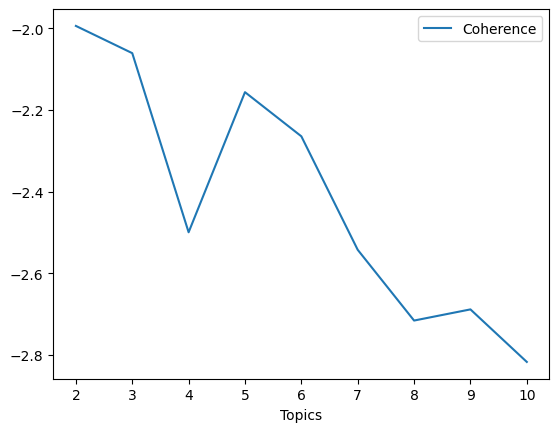

In [6]:
def calculate_avg_coherence(topics):
    avg_topic_coherence = sum([t[1] for t in topics]) / len(topics)

    return avg_topic_coherence


def plot_coherences_topics(tokens):
    # range of topics
    topics_range = range(2, 11, 1)
    model_results = {"Topics": [], "Coherence": []}
    for num_topics in topics_range:
        top_topics = find_topics(tokens.dropna(), num_topics=num_topics)

        avg_coherence = calculate_avg_coherence(top_topics)

        model_results["Topics"].append(num_topics)
        model_results["Coherence"].append(avg_coherence)

    pd.DataFrame(model_results).set_index("Topics").plot()


docs_tokens = clean_tokenize_text(documents)
docs_bigrams = append_bigrams(docs_tokens)
coherences_df = plot_coherences_topics(docs_bigrams["tokens"])

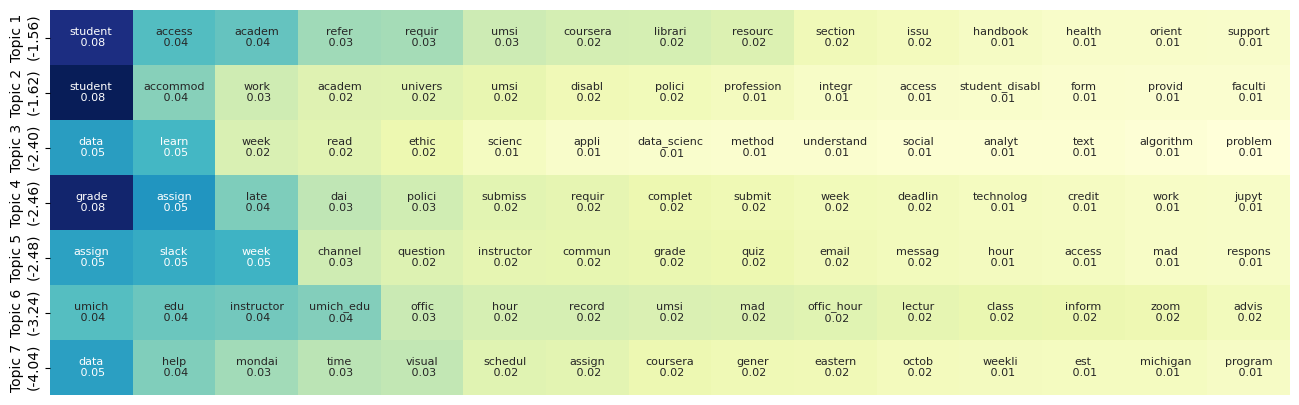

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_most_popular_topics(docs_df, num_topics, num_words):
    topics = find_topics(docs_df["tokens"], num_topics=num_topics)

    probs = []
    words = []
    coherences = []
    for topic in topics:
        topic_probs, coherence = topic
        probs.append([prob for prob, _ in topic_probs])
        words.append([word for _, word in topic_probs])
        coherences.append(coherence)

    df_probs = pd.DataFrame(probs, index=[i for i in range(len(probs))])
    df_words = pd.DataFrame(words, index=[i for i in range(len(words))])

    df_probs = df_probs.iloc[:, :num_words]
    df_words = df_words.iloc[:, :num_words]

    annotations = np.array(
        [
            f"{string}\n {value:.2f}"
            for string, value in zip(
                np.array(df_words).flatten(),
                np.array(df_probs).flatten(),
            )
        ]
    ).reshape(num_topics, num_words)

    plt.figure(figsize=(16, 5))
    ax = sns.heatmap(
        df_probs,
        annot=annotations,
        annot_kws={"fontsize": 8},
        fmt="",
        cmap="YlGnBu",
        cbar=False,
    )

    yticklabels = [f"Topic {i}\n({c:.2f})" for i, c in enumerate(coherences, 1)]
    ax.set(xlabel=None, xticklabels=[], yticklabels=yticklabels)
    ax.tick_params(bottom=False)


docs_tokens = clean_tokenize_text(documents)
docs_bigrams = append_bigrams(docs_tokens)
plot_most_popular_topics(docs_bigrams, 7, 15)

|     | Topic                           |
| --- | ------------------------------- |
| 1   | student resources               |
| 2   | assignments                     |
| 3   | communication                   |
| 4   | assignments 2 (schedule?)       |
| 5   | university                      |
| 6   | academic support                |
| 7   | course work (readings, quizzes) |
